In [1]:
import pandas as pd
import numpy as np
import json
import swifter
import nltk
import string
import re
import ast
import emoji_data_python
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import codecs
from matplotlib import pyplot as plt
import seaborn as sns

/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [107]:
df_comments = pd.read_csv("./rb_data/all_comments.csv", parse_dates=['createdAt', 'updatedAt'], header=0)
df_users = pd.read_csv("./rb_data/all_users.csv", header=0)
df_posts = pd.read_csv("./rb_data/all_posts.csv", parse_dates=['createdAt', 'updatedAt'], header=0)
df_report_user = pd.read_csv("./rb_data/all_report_user.csv", parse_dates=['createdAt', 'updatedAt'], header=0)

In [71]:
df_users.head()

,id,email,username,password,firstName,lastName,fullName,profilePic,isMod,isObserver,instructions,createdAt,updatedAt,isPuppet,suspicious,disabled
0,1976,miho@dartpost.com,miho,$2a$10$9NrDj7dEYDHgK4vL0kTCbOmY07dM/ptcF2dVD8J...,NaN,NaN,NaN,https://dartmouth-socialplatform.s3.us-east-2....,t,f,https://docs.google.com/document/d/e/2PACX-1vQ...,2020-08-28 20:01:01.253+00,2020-08-28 20:01:01.253+00,f,f,f
1,1977,ModBessler@dartpost.org,ModB,$2a$10$iyHu9zlIoZ5JW7ErGgfCvueRa3tMGPfx6GlkE//...,NaN,NaN,NaN,https://dartmouth-socialplatform.s3.us-east-2....,t,f,https://docs.google.com/document/d/e/2PACX-1vQ...,2020-08-28 20:15:20.792+00,2020-08-28 20:15:20.792+00,f,f,f
2,1980,dapang@dartpost.com,RuiboLiu,$2a$10$dxRTsGeeutRAWhpYOGTwwek2x2CgGxvKeEfKmqQ...,NaN,NaN,NaN,https://dartmouth-socialplatform.s3.us-east-2....,t,f,https://docs.google.com/document/d/e/2PACX-1vQ...,2020-08-28 20:20:59.307+00,2020-08-28 20:20:59.307+00,f,f,f
3,1981,ruiliu@dartpost.org,ruiliu,$2a$10$dXK/0H8f9uaYixNAEvrsBO/XoldMqsg4Q9K5J/q...,NaN,NaN,NaN,https://dartmouth-socialplatform.s3.us-east-2....,t,f,https://docs.google.com/document/d/e/2PACX-1vQ...,2020-08-29 21:04:59.74+00,2020-08-29 21:04:59.74+00,f,f,f
4,1982,blake@dartpost.com,sarah_king,$2a$10$jevIf3bniJDDK7lebLGicO0T1W/Xg/Q1yj.icca...,NaN,NaN,NaN,https://dartmouth-socialplatform.s3.us-east-2....,t,f,https://docs.google.com/document/d/e/2PACX-1vQ...,2020-09-01 20:20:02.988+00,2020-09-01 20:20:02.988+00,f,f,f


In [5]:
df_socks_assigns = pd.read_csv('./assigns/sockpuppet_assigned.csv', header=0)

In [158]:
df_socks_assigns['strategy'].value_counts()

OVERT           81
UNRESTRICTED    73
COVERT          56
Name: strategy, dtype: int64

In [128]:
df_posts = df_posts[df_posts['AuthorId'].notna()]  # filter our missing data

In [6]:
df_socks_assigns['strategy'].value_counts()

OVERT           81
UNRESTRICTED    73
COVERT          56
Name: strategy, dtype: int64

In [129]:
# store the roles in three lists
sockpuppets, participants, observers = [], [], []
for idx, row in df_users.iterrows():
    if 'dartpost' in row['email']:
        participants.append(row['id'])
    if 'observer' in row['email']:
        observers.append(row['id'])
    if 'sockpuppet' in row['email']:
        sockpuppets.append(row['id'])

In [130]:
# set a new column in posts with actual roles
df_posts['AuthorId'] = [int(id) for id in df_posts['AuthorId'].tolist()]
def return_role(text):
    if text in participants:
        return 'participant'
    if text in observers:
        return 'observer'
    else:
        return 'sockpuppet'

In [131]:
df_posts['role'] = df_posts['AuthorId'].swifter.allow_dask_on_strings().apply(return_role)

In [132]:
df_posts.head()

,id,text,picture_url,parent_id,root_id,is_marked,tags,createdAt,updatedAt,AuthorId,is_trending,role
0,93,I think that we should move away from nuclear ...,NaN,NaN,NaN,f,"{nuclear,energy,enviroment}",2020-09-03 01:59:10.051000+00:00,2020-09-04 13:08:51.133000+00:00,2580,f,participant
1,94,"Given the security put in place since 911, it ...",NaN,NaN,NaN,f,{TerroristAttack},2020-09-03 02:28:29.002000+00:00,2020-09-04 13:08:51.133000+00:00,2593,f,participant
2,95,NaN,NaN,NaN,NaN,t,"{""""}",2020-09-03 02:31:10.028000+00:00,2020-09-03 02:34:29.992000+00:00,2611,f,participant
3,96,It is crucial that the United States plays a r...,NaN,NaN,NaN,f,{Worldaffairs},2020-09-03 02:34:07.312000+00:00,2020-09-04 13:08:51.133000+00:00,2593,f,participant
4,97,Strongly disapprove of a two percent annual ta...,NaN,NaN,NaN,f,{WealthTax},2020-09-03 02:36:27.825000+00:00,2020-09-04 13:08:51.133000+00:00,2593,f,participant


In [133]:
# pick the columns of our interests
sel_cols = ['text', 'tags', 'createdAt', 'updatedAt', 'AuthorId', 'role']
df_posts = df_posts[sel_cols]
df_posts.head()

,text,tags,createdAt,updatedAt,AuthorId,role
0,I think that we should move away from nuclear ...,"{nuclear,energy,enviroment}",2020-09-03 01:59:10.051000+00:00,2020-09-04 13:08:51.133000+00:00,2580,participant
1,"Given the security put in place since 911, it ...",{TerroristAttack},2020-09-03 02:28:29.002000+00:00,2020-09-04 13:08:51.133000+00:00,2593,participant
2,NaN,"{""""}",2020-09-03 02:31:10.028000+00:00,2020-09-03 02:34:29.992000+00:00,2611,participant
3,It is crucial that the United States plays a r...,{Worldaffairs},2020-09-03 02:34:07.312000+00:00,2020-09-04 13:08:51.133000+00:00,2593,participant
4,Strongly disapprove of a two percent annual ta...,{WealthTax},2020-09-03 02:36:27.825000+00:00,2020-09-04 13:08:51.133000+00:00,2593,participant


In [19]:
# double check the datetime
df_posts.dtypes

text                      object
tags                      object
createdAt    datetime64[ns, UTC]
updatedAt    datetime64[ns, UTC]
AuthorId                   int64
role                      object
dtype: object

In [20]:
df_posts = df_posts.set_index('createdAt')
df_posts.head()

,text,tags,updatedAt,AuthorId,role
createdAt,,,,,
2020-09-03 01:59:10.051000+00:00,I think that we should move away from nuclear ...,"{nuclear,energy,enviroment}",2020-09-04 13:08:51.133000+00:00,2580,participant
2020-09-03 02:28:29.002000+00:00,"Given the security put in place since 911, it ...",{TerroristAttack},2020-09-04 13:08:51.133000+00:00,2593,participant
2020-09-03 02:31:10.028000+00:00,NaN,"{""""}",2020-09-03 02:34:29.992000+00:00,2611,participant
2020-09-03 02:34:07.312000+00:00,It is crucial that the United States plays a r...,{Worldaffairs},2020-09-04 13:08:51.133000+00:00,2593,participant
2020-09-03 02:36:27.825000+00:00,Strongly disapprove of a two percent annual ta...,{WealthTax},2020-09-04 13:08:51.133000+00:00,2593,participant


In [83]:
# assign post count for two roles
df_posts['participant'] = np.where(df_posts['role']== 'participant', 1, 0)
df_posts['sockpuppet'] = np.where(df_posts['role']== 'sockpuppet', 1, 0)

In [84]:
df_posts.head()

,text,tags,updatedAt,AuthorId,role,participant,sockpuppet
createdAt,,,,,,,
2020-09-03 01:59:10.051000+00:00,I think that we should move away from nuclear ...,"{nuclear,energy,enviroment}",2020-09-04 13:08:51.133000+00:00,2580,participant,1,0
2020-09-03 02:28:29.002000+00:00,"Given the security put in place since 911, it ...",{TerroristAttack},2020-09-04 13:08:51.133000+00:00,2593,participant,1,0
2020-09-03 02:31:10.028000+00:00,NaN,"{""""}",2020-09-03 02:34:29.992000+00:00,2611,participant,1,0
2020-09-03 02:34:07.312000+00:00,It is crucial that the United States plays a r...,{Worldaffairs},2020-09-04 13:08:51.133000+00:00,2593,participant,1,0
2020-09-03 02:36:27.825000+00:00,Strongly disapprove of a two percent annual ta...,{WealthTax},2020-09-04 13:08:51.133000+00:00,2593,participant,1,0


In [85]:
# recompose a dataframe to count the posts from sock and participants
df_posts_hour = pd.DataFrame(df_posts.index.to_period('h'))
df_posts_hour = df_posts_hour.reset_index()
del df_posts_hour['index']
df_posts_hour['sockpuppet'] = df_posts['sockpuppet'].to_list()
df_posts_hour['participant'] = df_posts['participant'].to_list()
df_posts_hour.head()

/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1091: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


,createdAt,sockpuppet,participant
0,2020-09-03 01:00,0,1
1,2020-09-03 02:00,0,1
2,2020-09-03 02:00,0,1
3,2020-09-03 02:00,0,1
4,2020-09-03 02:00,0,1


In [87]:
hourly = df_posts_hour.groupby(['createdAt']).sum()

In [88]:
# calculate average
hourly['sockpuppet'] /= 210
hourly['participant'] /= 160
hourly.head()

,sockpuppet,participant
createdAt,,
2020-09-03 01:00,0.000000,0.00625
2020-09-03 02:00,0.000000,0.05625
2020-09-03 03:00,0.000000,0.07500
2020-09-03 04:00,0.000000,0.01250
2020-09-03 05:00,0.004762,0.00000


Text(0, 0.5, 'Average Post / Hour')

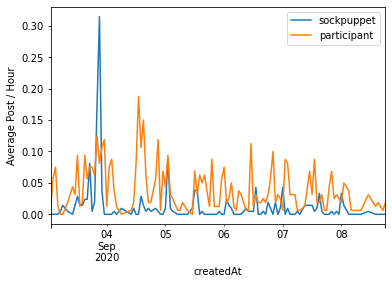

In [89]:
hourly_fig = hourly.plot()
plt.ylabel('Average Post / Hour')

In [90]:
hourly_fig.figure.savefig("hourly_posts.pdf")

In [91]:
# now we dive into three strategies

In [110]:
# clean user table
sel_user_columns = ['id', 'email']
df_users = df_users[sel_user_columns]
df_users.head()

,id,email
0,1976,miho@dartpost.com
1,1977,ModBessler@dartpost.org
2,1980,dapang@dartpost.com
3,1981,ruiliu@dartpost.org
4,1982,blake@dartpost.com


In [116]:
df_socks = df_users[df_users['id'].isin(sockpuppets)]
df_socks.head()

,id,email
94,2361,Connor_6191@sockpuppet.com
95,2362,Luke_1653@sockpuppet.com
96,2363,Cody_1227@sockpuppet.com
97,2364,Diamond_8596@sockpuppet.com
98,2365,Carly_7033@sockpuppet.com


In [117]:
df_socks = df_socks.reset_index(drop=True)
df_socks.head()

,id,email
0,2361,Connor_6191@sockpuppet.com
1,2362,Luke_1653@sockpuppet.com
2,2363,Cody_1227@sockpuppet.com
3,2364,Diamond_8596@sockpuppet.com
4,2365,Carly_7033@sockpuppet.com


In [120]:
# get strategy for each sock
df_socks_assigns.head(2)

,email,username,password,sock,topic_0,pos_0,topic_1,pos_1,topic_2,pos_2,strategy,turk_ids
0,Connor_6191@sockpuppet.com,Connor_6191,zefbfh,0,How strongly do you favor or oppose the use of...,Strongly oppose,How likely is it that the Dow Jones will end t...,Yes,How strongly would you approve or disapprove o...,Strongly disapprove,UNRESTRICTED,AVMBUHD8M055F
1,Luke_1653@sockpuppet.com,Luke_1653,iyjfba,0,How strongly do you favor or oppose the use of...,Strongly oppose,How likely is it that the Dow Jones will end t...,Yes,How strongly would you approve or disapprove o...,Strongly disapprove,UNRESTRICTED,AVMBUHD8M055F


In [124]:
# merge two dataframes based on email
merged_socks = pd.merge(df_socks, df_socks_assigns, on='email')
merged_socks.head(2)

,id,email,username,password,sock,topic_0,pos_0,topic_1,pos_1,topic_2,pos_2,strategy,turk_ids
0,2361,Connor_6191@sockpuppet.com,Connor_6191,zefbfh,0,How strongly do you favor or oppose the use of...,Strongly oppose,How likely is it that the Dow Jones will end t...,Yes,How strongly would you approve or disapprove o...,Strongly disapprove,UNRESTRICTED,AVMBUHD8M055F
1,2362,Luke_1653@sockpuppet.com,Luke_1653,iyjfba,0,How strongly do you favor or oppose the use of...,Strongly oppose,How likely is it that the Dow Jones will end t...,Yes,How strongly would you approve or disapprove o...,Strongly disapprove,UNRESTRICTED,AVMBUHD8M055F


In [125]:
covert, overt, unrestricted = [], [], []
for idx, row in merged_socks.iterrows():
    if row['strategy'] == 'UNRESTRICTED':
        unrestricted.append(row['id'])
    if row['strategy'] == 'COVERT':
        covert.append(row['id'])
    if row['strategy'] == 'OVERT':
        overt.append(row['id'])

In [134]:
def return_strategy(text):
    if text in covert:
        return 'covert'
    if text in overt:
        return 'overt'
    else:
        return 'unrestricted'

In [148]:
df_posts = df_posts[df_posts['AuthorId'].isin(sockpuppets)]
df_posts.head(2)

,text,tags,createdAt,updatedAt,AuthorId,role,strategy,covert,overt,unrestricted
24,American has seen itself as the policeman and ...,"{""""}",2020-09-03 05:53:41.910000+00:00,2020-09-03 05:53:42.052000+00:00,2540,sockpuppet,covert,1,0,0
25,Absolutely! The preservation of the environmen...,NaN,2020-09-03 06:05:01.123000+00:00,2020-09-03 06:05:01.135000+00:00,2444,sockpuppet,overt,0,1,0


In [149]:
df_posts['strategy'] = df_posts['AuthorId'].swifter.allow_dask_on_strings().apply(return_strategy)

/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [153]:
# the distribution of strategy in all sock posts
df_posts['strategy'].value_counts()

covert          193
overt            99
unrestricted     18
Name: strategy, dtype: int64

In [154]:
# assign post count for two roles
df_posts['covert'] = np.where(df_posts['strategy']== 'covert', 1, 0)
df_posts['overt'] = np.where(df_posts['strategy']== 'overt', 1, 0)
df_posts['unrestricted'] = np.where(df_posts['strategy']== 'unrestricted', 1, 0)

/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [155]:
df_posts.head(5)

,text,tags,createdAt,updatedAt,AuthorId,role,strategy,covert,overt,unrestricted
24,American has seen itself as the policeman and ...,"{""""}",2020-09-03 05:53:41.910000+00:00,2020-09-03 05:53:42.052000+00:00,2540,sockpuppet,covert,1,0,0
25,Absolutely! The preservation of the environmen...,NaN,2020-09-03 06:05:01.123000+00:00,2020-09-03 06:05:01.135000+00:00,2444,sockpuppet,overt,0,1,0
26,"Of course! The economy can wait, destruction o...",NaN,2020-09-03 06:08:59.136000+00:00,2020-09-03 06:08:59.147000+00:00,2444,sockpuppet,overt,0,1,0
27,"So, I don't know about you, but I'm about done...",{covid},2020-09-03 06:14:12.939000+00:00,2020-09-04 13:08:51.133000+00:00,2542,sockpuppet,covert,1,0,0
29,Am I the only one terrified of the unknown dan...,"{""""}",2020-09-03 08:26:01.216000+00:00,2020-09-03 08:26:01.230000+00:00,2443,sockpuppet,overt,0,1,0


In [156]:
df_posts = df_posts.set_index('createdAt')
df_posts_hour = pd.DataFrame(df_posts.index.to_period('h'))
df_posts_hour = df_posts_hour.reset_index()
del df_posts_hour['index']
df_posts_hour['covert'] = df_posts['covert'].to_list()
df_posts_hour['overt'] = df_posts['overt'].to_list()
df_posts_hour['unrestricted'] = df_posts['unrestricted'].to_list()
df_posts_hour.head()

/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1091: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


,createdAt,covert,overt,unrestricted
0,2020-09-03 05:00,1,0,0
1,2020-09-03 06:00,0,1,0
2,2020-09-03 06:00,0,1,0
3,2020-09-03 06:00,1,0,0
4,2020-09-03 08:00,0,1,0


In [157]:
hourly_socks = df_posts_hour.groupby(['createdAt']).sum()

In [159]:
hourly_socks['covert'] /= 56
hourly_socks['overt'] /= 81
hourly_socks['unrestricted'] /= 73

Text(0, 0.5, 'Average Post / Hour')

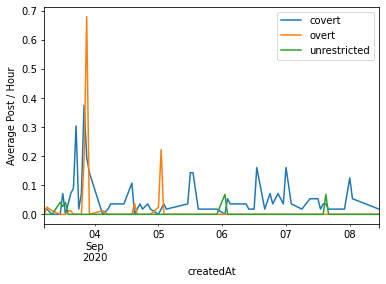

In [161]:
hourly_socks_fig = hourly_socks.plot()
plt.ylabel('Average Post / Hour')

In [162]:
hourly_socks_fig.figure.savefig("./hourly_posts_socks.pdf")